In [20]:
from typing import Any, List, Tuple

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import make_scorer
from pipe.baseline import Baseline

In [21]:
pd.set_option("display.max_rows", None)  # 行数の上限を設定しない
pd.set_option("display.max_columns", None)  # 列数の上限を設定しない
pd.set_option("display.max_colwidth", None)  # 列の幅を制限しない

In [22]:
df_train = pd.read_csv("../data/train.csv")

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [23]:
print(
    df_train[
        [
            "OverallQual",
            "GrLivArea",
            "GarageCars",
            "TotalBsmtSF",
            "FullBath",
            "YearBuilt",
        ]
    ]
    .isnull()
    .sum()
)

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64


In [24]:
df_numeric_features = df_train.select_dtypes(include=[np.number])
df_categorical_features = df_train.select_dtypes(exclude=[np.number])

df_numeric_features.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [25]:
num_features = len(df_numeric_features)

num_features

1460

## y軸住宅価格、横軸数値変数として散布図をプロット

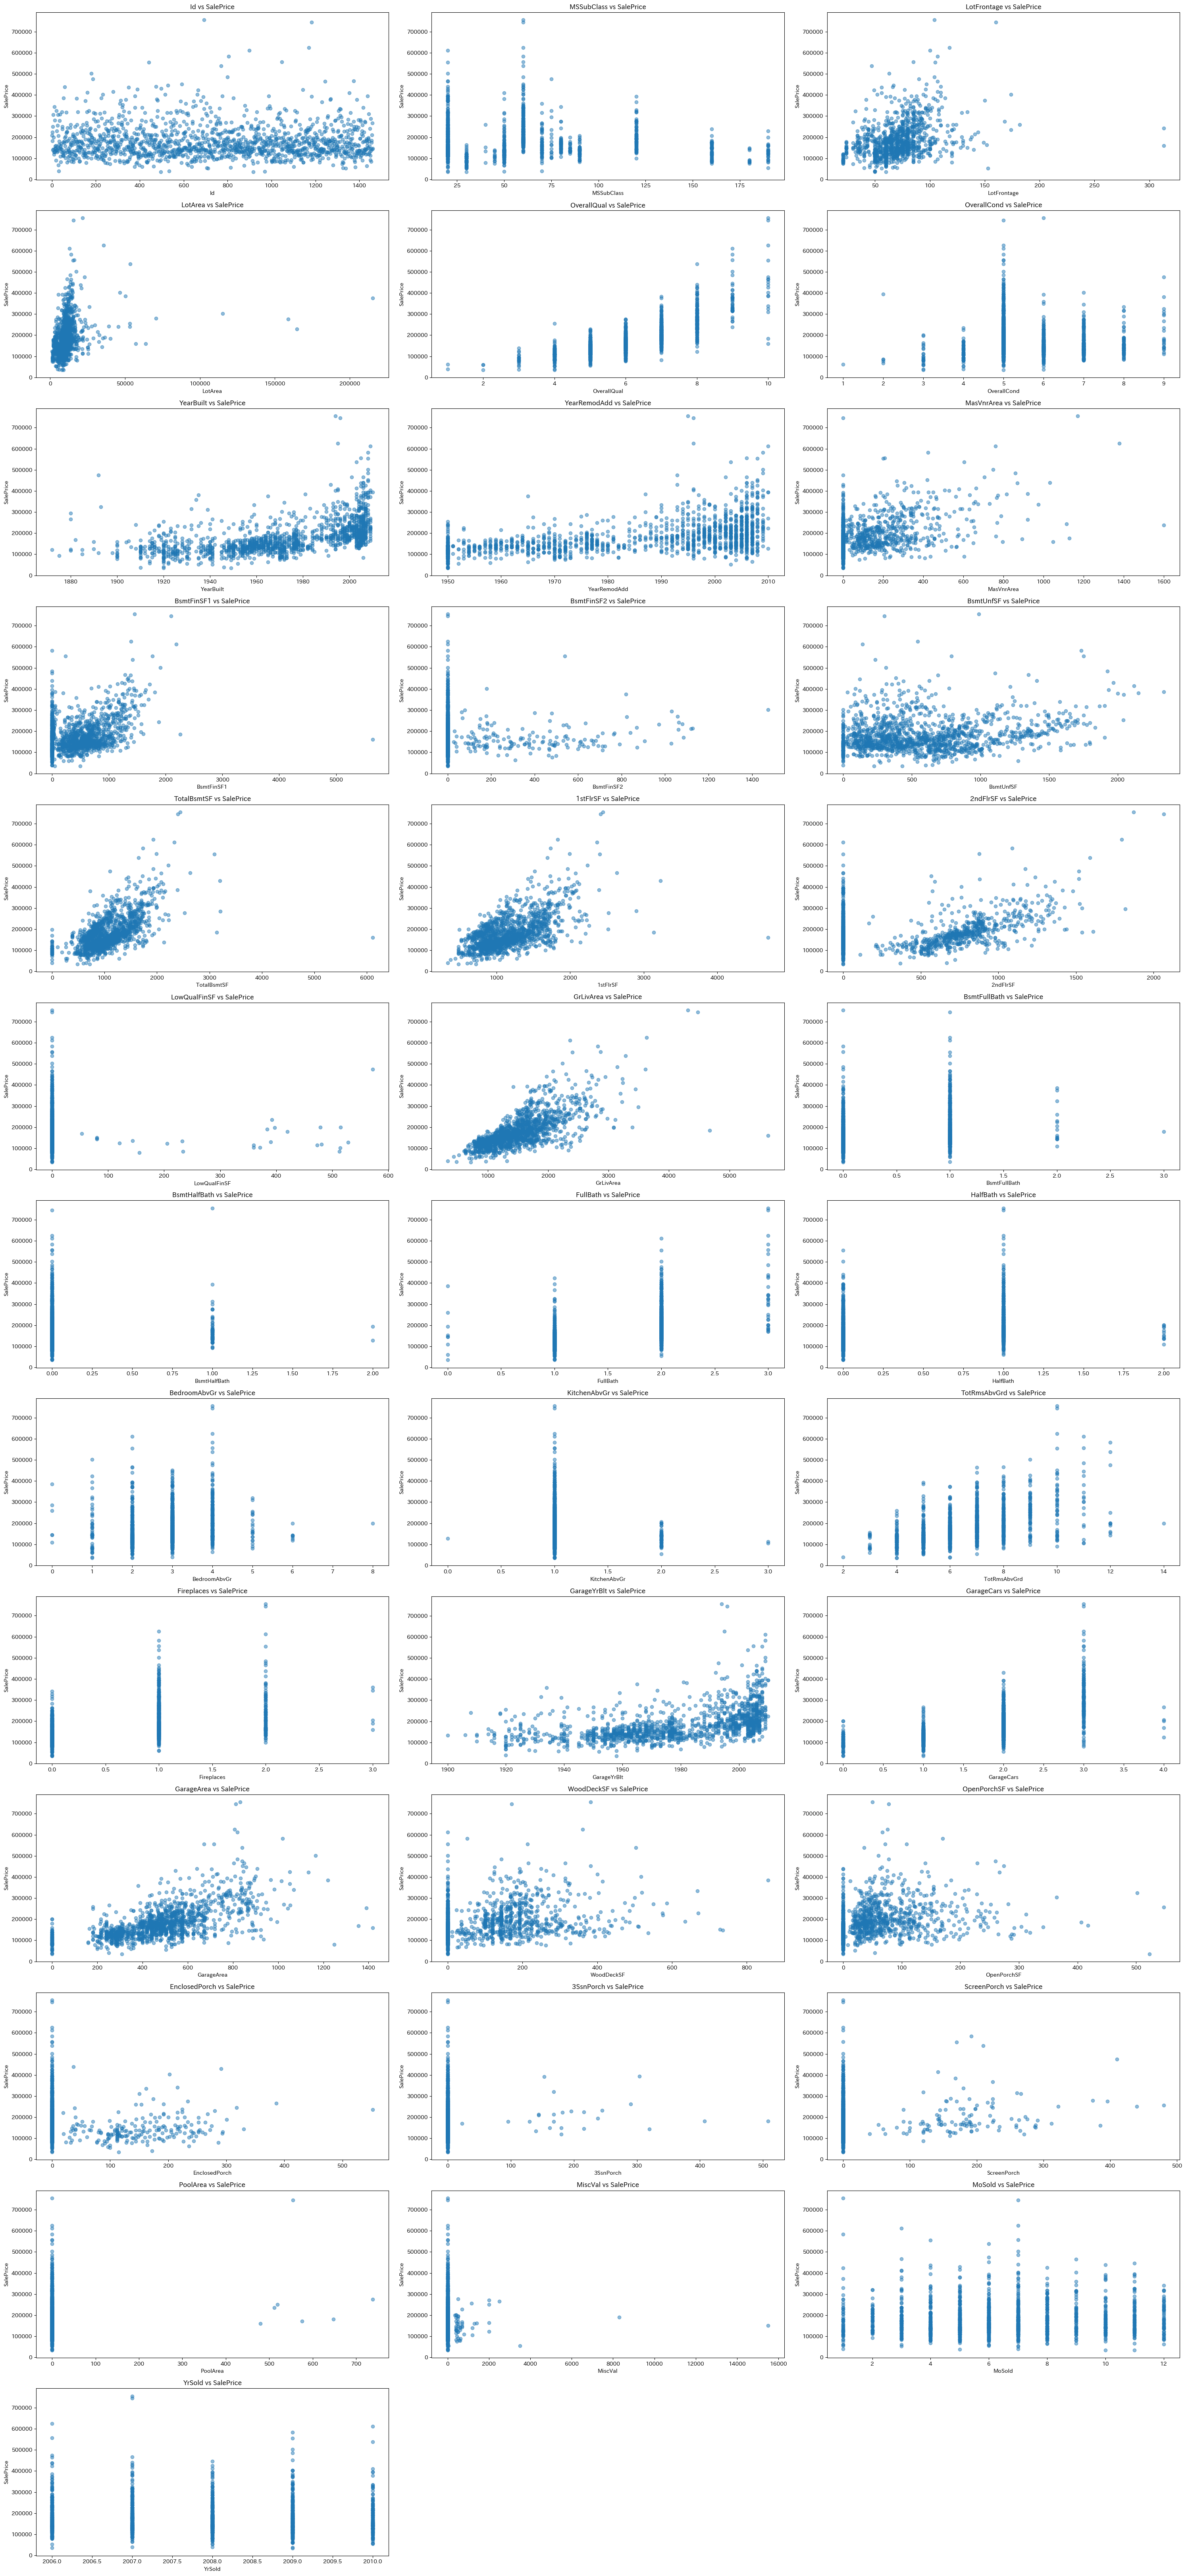

In [26]:
# 数値データのカラムのみ選択
numeric_features = df_train.select_dtypes(include=["int64", "float64"]).columns

# 目的変数（SalePrice）を除く
features = [feature for feature in numeric_features if feature != "SalePrice"]

# グラフの作成
num_features = len(features)
num_cols = 3  # 列数
num_rows = (num_features + num_cols - 1) // num_cols  # 必要な行数を計算

plt.figure(figsize=(10 * num_cols, 5 * num_rows))  # グラフのサイズを調整

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(df_train[feature], df_train["SalePrice"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.title(f"{feature} vs SalePrice")

plt.tight_layout()
plt.show()

## 相関行列のヒートマップをプロット

<Axes: >

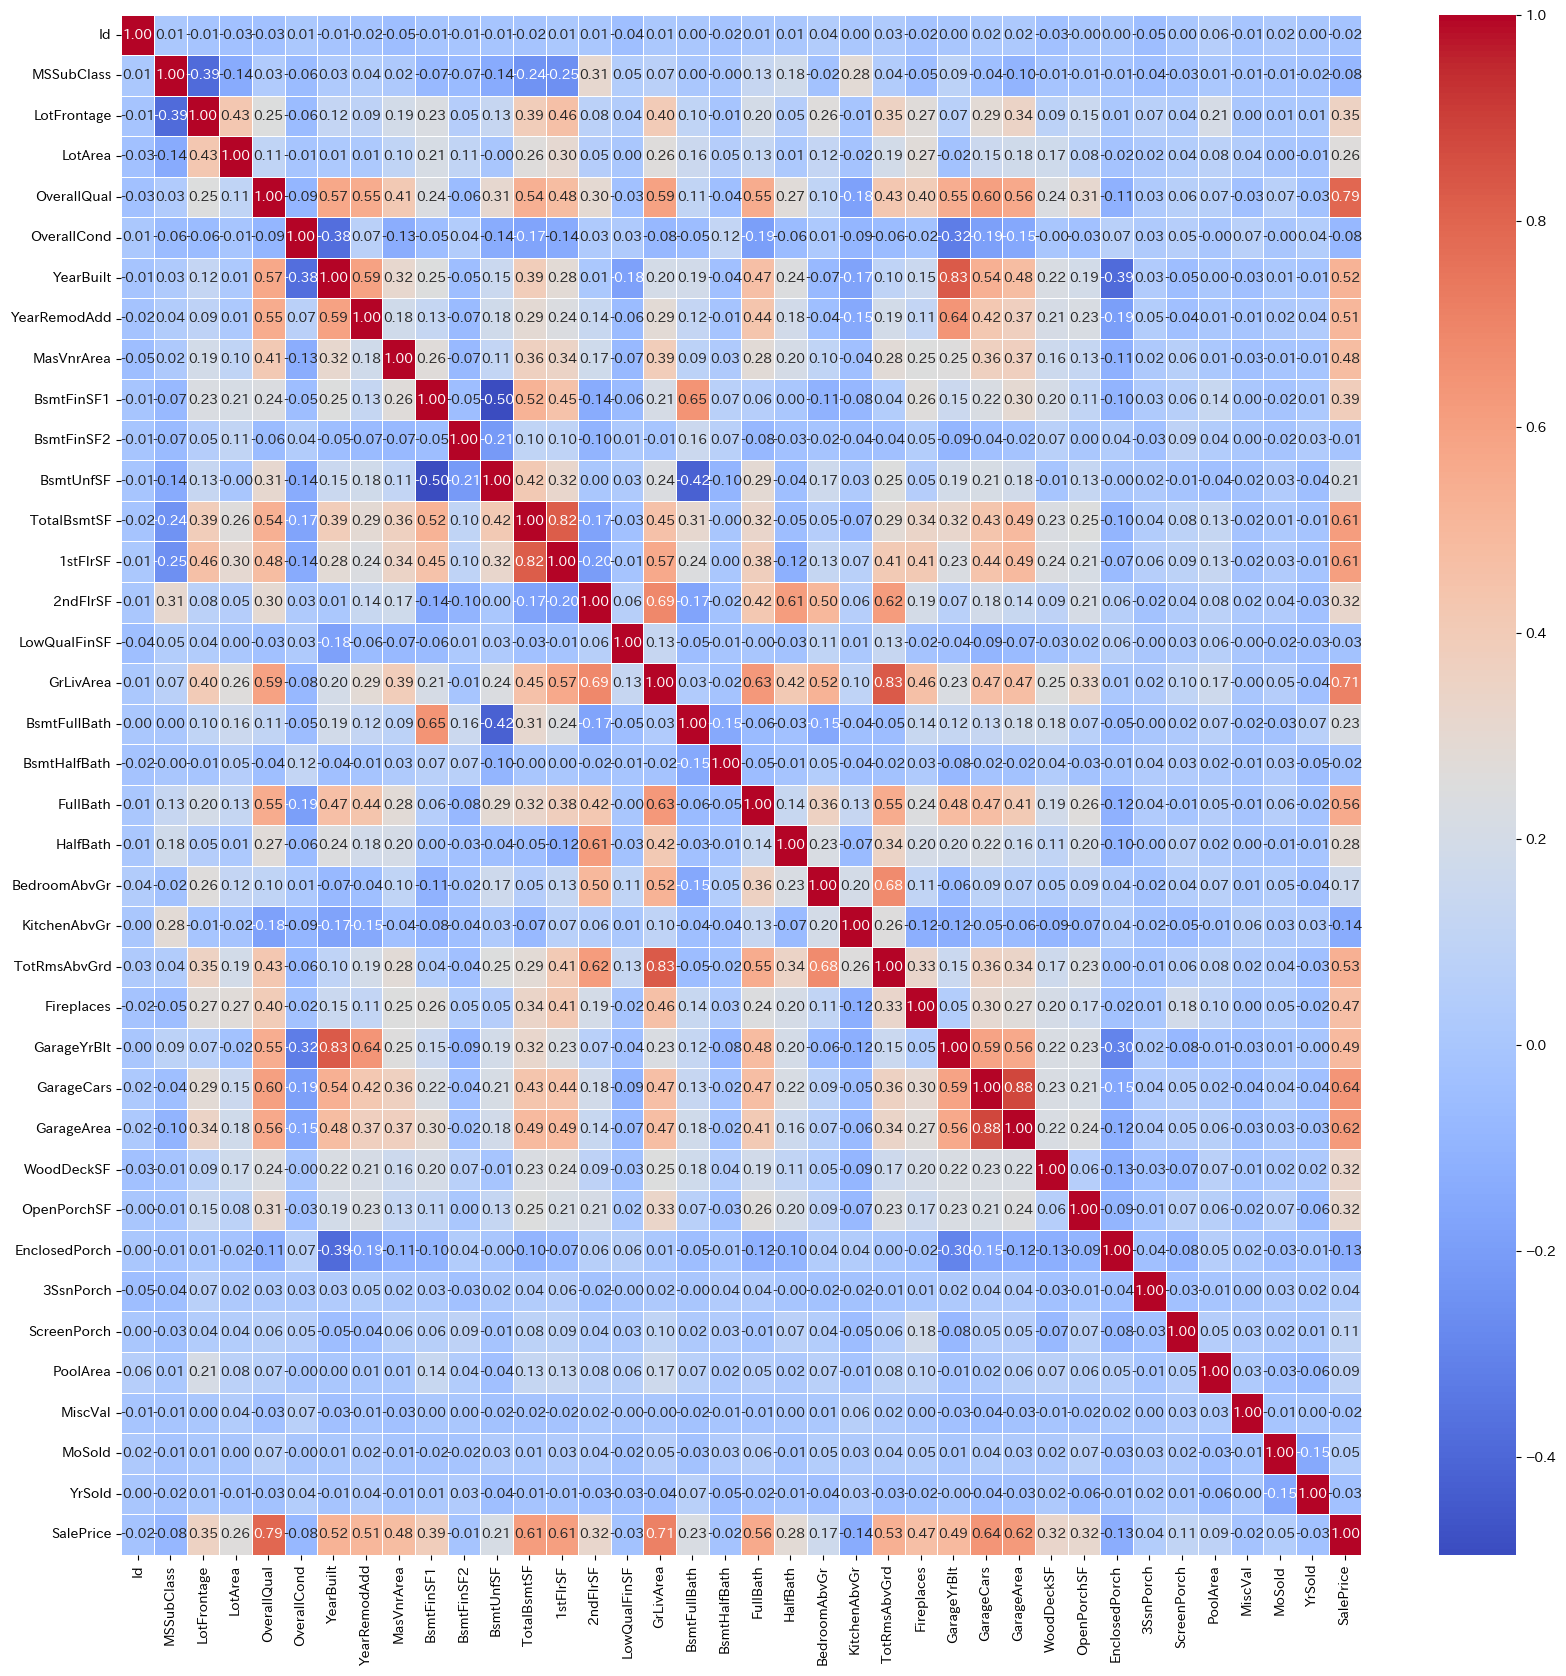

In [27]:
corr_err = df_numeric_features.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_err,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
)

## ベースラインモデルの構築

In [28]:
X = df_train[
    ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt"]
]
y = np.log1p(df_train["SalePrice"])

model = LGBMRegressor(verbose=-1)

skf = KFold(n_splits=5, shuffle=True, random_state=0)

# 交差検証
scores = cross_val_score(model, X, y, cv=skf, scoring="neg_root_mean_squared_error")

print(f"mean: {scores.mean()}")

mean: -0.1698398434088696


In [29]:
df_test = pd.read_csv("../data/test.csv")

model.fit(X, y)

LGBMRegressor(verbose=-1)

In [30]:
X_test = df_test[
    ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt"]
]
y_pred = model.predict(X_test)

df_submit = pd.DataFrame({"Id": df_test["Id"], "SalePrice": y_pred})

df_submit.to_csv("../data/submission.csv", index=False)

## パイプ化したベースラインのデバッグ

In [31]:
bl = Baseline(
    train_file_path="../data/train.csv",
)

impls, score = bl.run()

print(score)
print(impls)

-0.16338634486217343
       feature  importance
0  OverallQual         268
1    GrLivArea         838
2   GarageCars         137
3  TotalBsmtSF         766
4     FullBath          59
5    YearBuilt         694
